In [ ]:
####
####

# September 12, 2025 - Added a few more comments and updated some of the target use-cases.

####
####

# AiZynthFinder Retrosynthesis Reaction Prediction

V.F. Scalfani and A.M. Fernandez, University of Alabama Libraries

Fall 2024 

## Anticipated Length of Workshop

1 hour

## Important Notes

This notebook is part of the Retrosynthesis Workshop materials, which aim to introduce computational cheminformatics techniques for retrosynthesis prediction. Please note the following:

1. **Educational Purpose**: The tutorials are designed for educational purposes to help you understand cheminformatics strategies for predicting synthetic routes. They are not intended to provide practical laboratory guidance.

2. **Practical Limitations**: The methods demonstrated here are template-based and pattern-driven, meaning they rely on predefined reaction templates and do not fully capture real-world chemistry complexities. It is important to note that computational models can produce inaccurate or incomplete predictions due to simplifications and assumptions within the algorithms, as well as limitations in their training data. Any application of the predicted reactions would require signficant additional research, including a thorough review of the relevant literature, synthesis planning, and safety assessments. In addition, see the articles referenced throughout the Retrosynthesis Workshop notebooks to learn more about specific model limitations.

3. **Intellectual Property**: The retrosynthetic prediction techniques in the tutorials use reaction data (and/or computer models derived from this data) from U.S. patents for training purposes. Synthetic pathways suggested by these models could potentially be protected by intellectual property laws.

For further details, please refer to the [repository README](https://github.com/UA-Libraries-Research-Data-Services/retrosynthesis/blob/main/README.md), [data README](https://github.com/UA-Libraries-Research-Data-Services/retrosynthesis/blob/main/X_Data/AA_README_data) and references in the tutorials for more information. Code in the notebook is [MIT licensed](https://github.com/ualibweb/retrosynthesis/blob/main/LICENSE).


## What is the purpose of this workshop?

This workshop will introduce the open-source AiZynthFinder retrosynthetic software (https://github.com/MolecularAI/aizynthfinder). AiZynthFinder includes a GUI version, a command-line version, and a Python interface. We will look at all three, but will spend the most time using the Python interface.

## Brief Description of Method

AiZynthFinder uses a reaction template-based approach for prediction. First, reaction templates (Reaction SMARTS patterns) are extracted from a large dataset of USPTO patent reactions (~1 million unique reactions). A neural network is then trained with the reactions and reaction templates (this training "learns" which transformations are associated with specific products/reactants). A Monte Carlo tree search algorithm (similar to Segler et al., 2018) is used to deconstruct target molecules into precursors and each pathway is guided by the neural network; that is, the neural network is used to prioritize and select a small subset of the most probable reaction templates to apply (< 50). Finally, a library of purchasable compounds is factored into the paths, where for example, the path can be considered complete if all precursors are commercially available (Thakkar et al 2020 and Genheden, S. et al. 2020).

In order to succesfully use AiZynthFinder, we need a basic understanding of some of the AI/ML terminology used in the configuration files and functions:

1. Expansion Policy - This refers to the neural network used to identify the most probable application of templates. There are two public models available within the AiZynthFinder package: (1) "USPTO" model trained on the USPTO patent reactions and "Ring Breaker", which is a model also trained on USPTO data, but optimized for prediction of ring system formations (Thakkar, A.; Selmi, N. et al. 2020 and Thakkar, A.; Kogej, T. et al. 2020).

2. Stock Policy - Collection of commercially available small molecules. AiZynthFinder has a collection from the ZINC database readily available for download.

3. Filter Policy - A filter policy is optional. This is a model that incorporates virtually created unfeasible reactions and is used to identify and eliminate unfeasible routes. AiZynthFinder has a public filter policy trained from USPTO (Genheden, S. 2020, ChemRXiv).

## References

* Thakkar, A.; Selmi, N.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. J. “Ring Breaker”: Neural Network Driven Synthesis Prediction of the Ring System Chemical Space. J. Med. Chem. 2020, 63 (16), 8791–8808. https://doi.org/10.1021/acs.jmedchem.9b01919.
* Thakkar, A.; Kogej, T.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. J. Datasets and Their Influence on the Development of Computer Assisted Synthesis Planning Tools in the Pharmaceutical Domain. Chem. Sci. 2020, 11 (1), 154–168. https://doi.org/10.1039/C9SC04944D.
* Genheden, S.; Thakkar, A.; Chadimová, V.; Reymond, J.-L.; Engkvist, O.; Bjerrum, E. AiZynthFinder: A Fast, Robust and Flexible Open-Source Software for Retrosynthetic Planning. J Cheminform 2020, 12 (1), 70. https://doi.org/10.1186/s13321-020-00472-1.
* Genheden, S.; Engkvist, O.; Bjerrum, E. J. A Quick Policy to Filter Reactions Based on Feasibility in AI-Guided Retrosynthetic Planning. November 25, 2020. https://doi.org/10.26434/chemrxiv.13280495.v1.
* Segler, M. H. S.; Preuss, M.; Waller, M. P. Planning Chemical Syntheses with Deep Neural Networks and Symbolic AI. Nature 2018, 555 (7698), 604–610. https://doi.org/10.1038/nature25978.
* AiZynthFinder Docs: https://molecularai.github.io/aizynthfinder/



## Local Setup for Python Environment

Here is a conda environment recipe (this installs RDKit, Jupyter, and everything we should need for today):

Linux:

```
conda create --name retro_aizynth_env
conda activate retro_aizynth_env
conda install -c conda-forge "python>=3.9,<3.11" "numpy<2.0" pip
pip install aizynthfinder[all]

```

*Note: If you are using Ubuntu Linux through WSL, you may need to install the `libxrender1` package (via apt install).*

For Mac, try the following recipe and note that with zsh shell, wrap the aizynthfinder[all] in quotes:

```
conda create --name retro_aizynth_env
conda activate retro_aizynth_env
conda install -c conda-forge "python>=3.9,<3.11" "numpy<2.0" pip jq
pip install 'aizynthfinder[all]'

```


## Download the Public Models and Datasets

In [2]:
# make a directory for aizynth data folder (if not already created)
import os

# Path to the folder expected
folder_path = 'aizynth_data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder if it does not exist
    os.makedirs(folder_path)
    print(f"Folder created: {folder_path}")
else:
    print("Folder already exists.")

Folder created: aizynth_data


In [3]:
# Download the AiZynth models and data (if needed)
# !download_public_data aizynth_data
import os
import subprocess
import glob

# Path to the folder expected
folder_path = 'aizynth_data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # Terminate if no folder
    print(f"Terminated, {folder_path} folder not found, see cell above to create.")
else:
    # Check for some Aizynthfiles already existing'
    uspto_files = glob.glob(os.path.join(folder_path, 'uspto*'))
    zinc_files = glob.glob(os.path.join(folder_path, 'zinc*'))
    con_file = glob.glob(os.path.join(folder_path, 'config*'))

    if uspto_files and zinc_files and con_file:
        # Terminate if these files are already downloaded
        print("Terminated, files starting with 'uspto', 'zinc', and 'config' are already present.")
    else:
        # If the files are not there, download the files using subprocess
        print("Downloading files...")
        # `download_public_data folder_path` is an aizynthfinder command line program
        subprocess.run(["download_public_data", folder_path])

uspto_model.onnx: 100%|██████████| 91.5M/91.5M [00:09<00:00, 9.82MB/s]
uspto_templates.csv.gz: 3.31MB [00:01, 2.01MB/s]
uspto_ringbreaker_model.onnx: 100%|██████████| 15.0M/15.0M [00:02<00:00, 5.76MB/s]
uspto_ringbreaker_templates.csv.gz: 374kB [00:01, 365kB/s]  
zinc_stock.hdf5: 100%|██████████| 663M/663M [00:45<00:00, 14.6MB/s]    
uspto_filter_model.onnx: 100%|██████████| 16.8M/16.8M [00:02<00:00, 6.80MB/s]


Configuration file written to config.yml


In [4]:
# Now CD to aizynth_data folder
import os
os.chdir('aizynth_data')

## GUI Version

*Some terminology and GUI figure notes:*

**State score** - Description from article: "The score reflects the fraction of solved precursors and
the number of reactions required to synthesize the target compound.
The score for a solved compound is close
to 1.0, whereas the score for an unsolved compound is
typically less than 0.8. However, it should be noted that
the score was designed to support the tree search and
is rather indiscriminate with regard to the quality of the
route (i.e. if it's a good route or not) and should be interpreted with care. (Genheden, S.; et al.J Cheminform 2020, 12 (1), 70. https://doi.org/10.1186/s13321-020-00472-1.)"

**Green Box** - precursor available in ZINC database

**Orange Box** - precursor not available in ZINC database

Here are some example targets to try (copy/paste into GUI when loaded):

```
# from the AiZynth Docs
Cc1cccc(c1N(CC(=O)Nc2ccc(cc2)c3ncon3)C(=O)C4CCS(=O)(=O)CC4)C

# from PubChem, CID 10615
CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2

# from PubChem, CID 74051576
CC1CCC(=C2C1CCC(=C2)C)C(C)COC(=O)C

# from Thakkar, A. et al. J. Med. Chem. 2020, 63 (16), 8791. https://doi.org/10.1021/acs.jmedchem.9b01919.
# Try this with both USPTO and Ring Breaker model and compare
CC(C)(C)C1=CC(C(=O)NCCN2CCOCC2)=C(S1)C1=CC=CC=C1
```

In [ ]:
# load the GUI and try it out!
from aizynthfinder.interfaces import AiZynthApp
app = AiZynthApp("config.yml")

## Command Line Version

First, create a local config file, named `config_local_CLI.yml`, save it to your current directory, this should be the `/aizynth_data` folder. Here is a basic config file below, which assumes that you will be running the `aizynthcli` from the same path of where the models/data are stored:

```
expansion:
  uspto:
    - uspto_model.onnx
    - uspto_templates.csv.gz
filter:
  uspto: uspto_filter_model.onnx
stock:
   zinc: zinc_stock.hdf5

```

In [6]:
# We can programmatically create this file:
config_content = """expansion:
  uspto:
    - uspto_model.onnx
    - uspto_templates.csv.gz
filter:
  uspto: uspto_filter_model.onnx
stock:
  zinc: zinc_stock.hdf5
"""

# Write the config content to a file
with open('config_local_CLI.yml', 'w') as file:
    file.write(config_content)

In [ ]:
# Run the CLI
# from PubChem, CID 10615
# CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2
!aizynthcli --config config_local_CLI.yml --smiles 'CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2'

The `aizynthcli` creates an output file `trees.json` which contains the prediction data. We will look more closely at the trees output using the Python interface and python dictionary data outputs, however, you could certainly parse this file with a program like `jq` (https://jqlang.github.io/jq/).

Here is a very brief example, **which assumes that you have `jq` installed**. `jq` should be in most Linux repositories (e.g., install via apt). On Mac, `jq` is available on conda-forge (see above). This was tested on Linux:

In [8]:
# Get the length of iterations paths with jq
!jq 'length' trees.json

21


In [9]:
# View the first sequence (starts with "type:mol")
!jq '.[0]' trees.json

{
  "type": "mol",
  "hide": false,
  "smiles": "CC(=O)N(c1ccccc1)c1ccccc1",
  "is_chemical": true,
  "in_stock": false,
  "children": [
    {
      "type": "reaction",
      "hide": false,
      "smiles": "[C:1]([CH3:2])(=[O:3])[N:5]([cH3:4])[cH3:6]>>Cl[C:1]([CH3:2])=[O:3].[cH3:4][N:5][cH3:6]",
      "is_reaction": true,
      "metadata": {
        "template_hash": "6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b",
        "classification": "0.0 Unrecognized",
        "library_occurence": 82,
        "policy_probability": 0.3776000142097473,
        "policy_probability_rank": 0,
        "policy_name": "uspto",
        "template_code": 17758,
        "template": "[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]",
        "mapped_reaction_smiles": "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:

In [10]:
# Extract out the state score for first idx
!jq '.[0]["scores"]["state score"]' trees.json

0.9976287063411217


In [11]:
# Extract out all state scores
!jq '.[]' trees.json | jq '.["scores"]["state score"]'

0.9976287063411217
0.9976287063411217
0.9976287063411217
0.9976287063411217
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894
0.994039853898894


In [12]:
# Extract out state score and number of reactions
!jq '.[]' trees.json | jq '[.scores."state score", .scores."number of reactions"] | @csv'

"0.9976287063411217,1"
"0.9976287063411217,1"
"0.9976287063411217,1"
"0.9976287063411217,1"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"
"0.994039853898894,2"


In [13]:
# OK, now extract out the predicted reaction smiles for the first sequence
!jq '.[0]["children"]' trees.json | jq '.[0]["metadata"]["mapped_reaction_smiles"]'

"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"


In [14]:
# To save the output as a variable, we can run the shell command as a python subprocess
import subprocess
command = "jq '.[0][\"children\"]' trees.json | jq '.[0][\"metadata\"][\"mapped_reaction_smiles\"]'"
result = subprocess.run(command, shell=True, capture_output=True)
rxn_smiles = result.stdout.strip().decode("utf-8")
rxn_smiles = rxn_smiles.strip('"')
print(rxn_smiles)

[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1


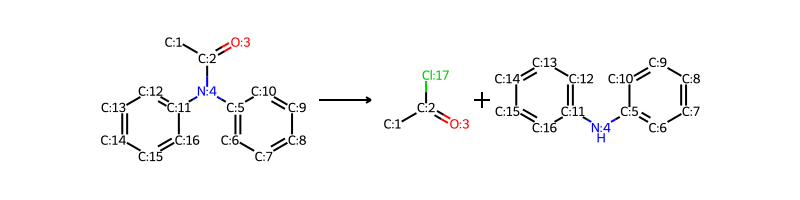

In [15]:
# Display rxn using rdkit
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = (600,200)
rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
rxn

In [16]:
# When there is more than one reaction in the sequence, it's a bit more complicated to use jq for indexing
# As there are nested reactions
# Look at sequence 4 with 2 reactions
!jq '.[4]' trees.json

{
  "type": "mol",
  "hide": false,
  "smiles": "CC(=O)N(c1ccccc1)c1ccccc1",
  "is_chemical": true,
  "in_stock": false,
  "children": [
    {
      "type": "reaction",
      "hide": false,
      "smiles": "[c:1]([cH2:2])[cH2:3]>>O[c:1]([cH2:2])[cH2:3]",
      "is_reaction": true,
      "metadata": {
        "template_hash": "0fe007c17f0280c4ab887b96e87283f665f06d2752027e2a54e19d69ed7400b8",
        "classification": "0.0 Unrecognized",
        "library_occurence": 120,
        "policy_probability": 0.0010999999940395355,
        "policy_probability_rank": 15,
        "policy_name": "uspto",
        "template_code": 2627,
        "template": "[c:2]:[cH;D2;+0:1]:[c:3]>>O-[c;H0;D3;+0:1](:[c:2]):[c:3]",
        "mapped_reaction_smiles": "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
      },
      "children": 

In [17]:
# Here is a solution from ChatGPT4, very cool that jq can do this!
!jq '.[4].children[] | recurse(.children[]?) | select(.type == "reaction") | .metadata.mapped_reaction_smiles' trees.json

"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
"[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:18].[NH:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"


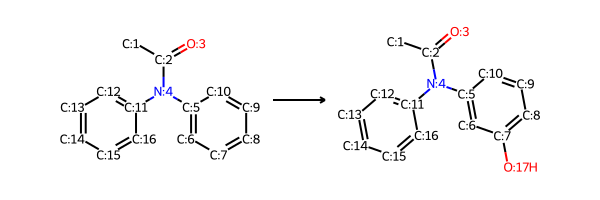

In [18]:
# depict rxns
rxn_smiles1 = "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1\
    >>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
rxn1 = rdChemReactions.ReactionFromSmarts(rxn_smiles1, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn1)
rxn1

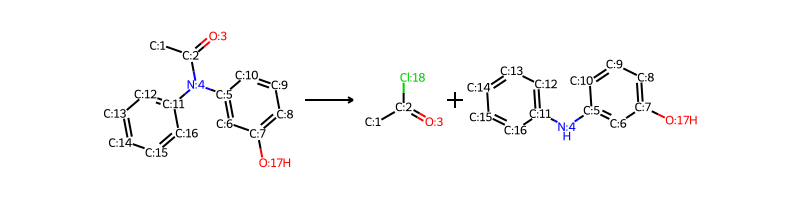

In [19]:
rxn_smiles2 = "[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1\
    >>[CH3:1][C:2](=[O:3])[Cl:18].[NH:4]([c:5]1[cH:6][c:7]([OH:17])[cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1"
rxn2 = rdChemReactions.ReactionFromSmarts(rxn_smiles2, useSmiles=True)
rdChemReactions.SanitizeRxn(rxn1)
rxn2

## Python Interface

In [ ]:
# Adapted from AiZynthFinder docs: https://molecularai.github.io/aizynthfinder/python_interface.html#
from aizynthfinder.aizynthfinder import AiZynthFinder
finder = AiZynthFinder(configfile="config.yml")

# Select policies
finder.stock.select("zinc")
finder.expansion_policy.select("uspto")
finder.filter_policy.select("uspto")

In [ ]:
# Get help on aizynthfinder main module
help(finder)

In [21]:
# Set the target molecule
# CID 10615
finder.target_smiles = "CC(=O)N(C1=CC=CC=C1)C2=CC=CC=C2"

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

In [22]:
# Get tree statistics
stats = finder.extract_statistics()
stats

{'target': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'search_time': 2.130122661590576,
 'first_solution_time': 0.4525489807128906,
 'first_solution_iteration': 1,
 'number_of_nodes': 224,
 'max_transforms': 4,
 'max_children': 42,
 'number_of_routes': 146,
 'number_of_solved_routes': 138,
 'top_score': 0.9976287063411217,
 'is_solved': True,
 'number_of_steps': 1,
 'number_of_precursors': 2,
 'number_of_precursors_in_stock': 2,
 'precursors_in_stock': 'CC(=O)Cl, c1ccc(Nc2ccccc2)cc1',
 'precursors_not_in_stock': '',
 'precursors_availability': 'zinc;zinc',
 'policy_used_counts': {'uspto': 223},
 'profiling': {'expansion_calls': 81,
  'reactants_generations': 329,
  'iterations': 100}}

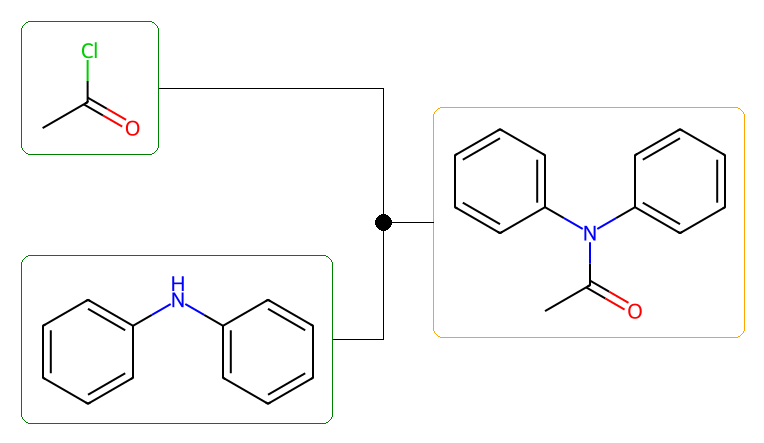

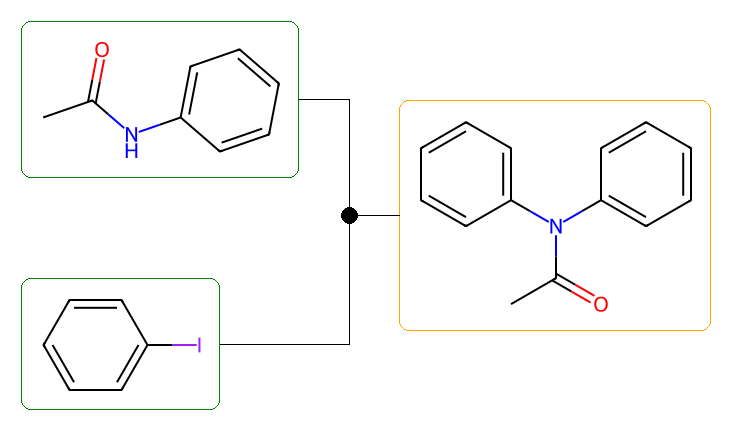

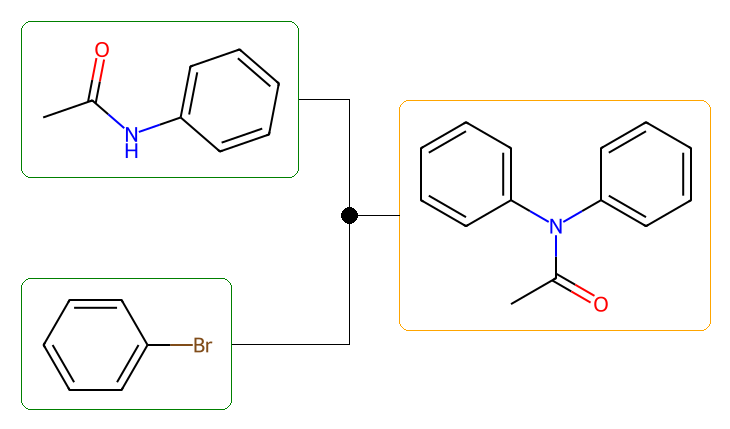

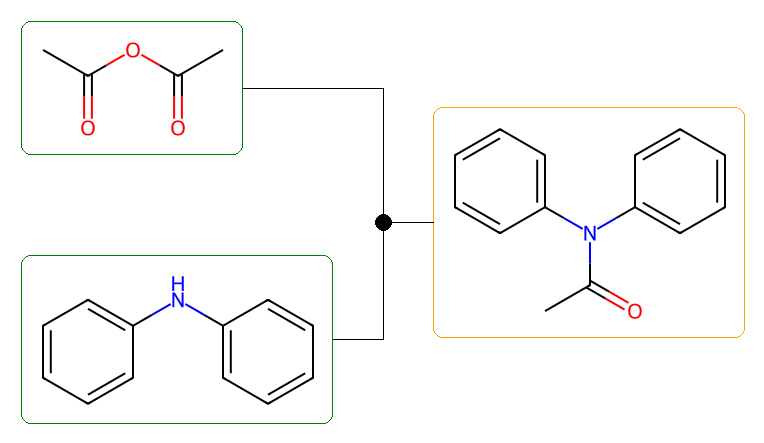

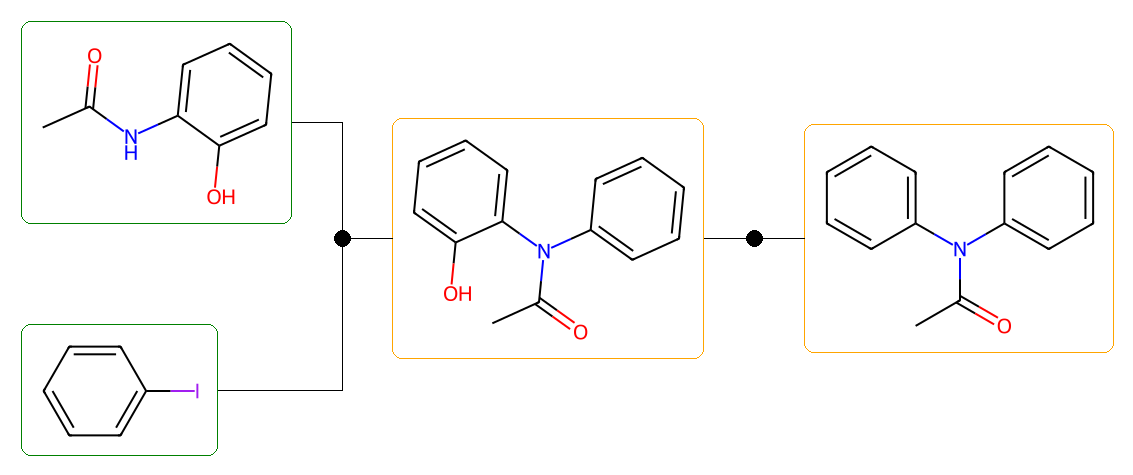

In [23]:
# Collect images of sequences
# display first 5
images = finder.routes.images
from IPython.display import display
for image in images[0:5]:
  display(image)

In [ ]:
# The analysis module can be used to collect the reaction routes and associated data
# https://molecularai.github.io/aizynthfinder/aizynthfinder.analysis.html

help(finder.routes)

In [24]:
# Get length of sequences
len(finder.routes.reaction_trees)

22

In [25]:
# Get scores of sequences
finder.routes.all_scores

[{'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.9976287063411217},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894},
 {'state score': 0.994039853898894}]

In [26]:
# Get the first reaction sequence
seq0 = finder.routes.reaction_trees[0]
seq0

In [27]:
# Print the associated data as a dictionary
seq0.to_dict(include_metadata=True)

{'route_metadata': {'created_at_iteration': 1, 'is_solved': True},
 'type': 'mol',
 'hide': False,
 'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'is_chemical': True,
 'in_stock': False,
 'children': [{'type': 'reaction',
   'hide': False,
   'smiles': '[C:1]([CH3:2])(=[O:3])[N:5]([cH3:4])[cH3:6]>>Cl[C:1]([CH3:2])=[O:3].[cH3:4][N:5][cH3:6]',
   'is_reaction': True,
   'metadata': {'template_hash': '6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b',
    'classification': '0.0 Unrecognized',
    'library_occurence': 82,
    'policy_probability': 0.3776000142097473,
    'policy_probability_rank': 0,
    'policy_name': 'uspto',
    'template_code': 17758,
    'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]',
    'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[N

In [28]:
# another example, seq4
finder.routes.reaction_trees[4].to_dict()

{'type': 'mol',
 'hide': False,
 'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'is_chemical': True,
 'in_stock': False,
 'children': [{'type': 'reaction',
   'hide': False,
   'smiles': '[c:1]([cH2:2])[cH2:3]>>O[c:1]([cH2:2])[cH2:3]',
   'is_reaction': True,
   'metadata': {'template_hash': '0fe007c17f0280c4ab887b96e87283f665f06d2752027e2a54e19d69ed7400b8',
    'classification': '0.0 Unrecognized',
    'library_occurence': 120,
    'policy_probability': 0.0010999999940395355,
    'policy_probability_rank': 15,
    'policy_name': 'uspto',
    'template_code': 2627,
    'template': '[c:2]:[cH;D2;+0:1]:[c:3]>>O-[c;H0;D3;+0:1](:[c:2]):[c:3]',
    'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[N:4]([c:5]1[c:6]([OH:17])[cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1'},
   'children': [{'type': 'mol',
     'hide': False,
     'smiles': 'CC(=O)N(c1ccccc1)c1ccccc1O',
 

In [ ]:
# We want to be able to extract out some information for all rxn sequences into
# a dictionary so that we can, for example, use the rxn template data and
# plot rxns later

# We will extract out the target smiles, rxns, templates, and stock status.
# We originally extracted the sequence data from this type of dictionary output shown above,
# however, this proved to be compilcated as it is recursive exercise when there is
# more than one reaction per sequence (see self-study code at the end of this notebook).

# Our sincere thanks to Samuel Genheden (AstraZeneca) for providing us starter code
# which uses the internal AiZynthFinder object instead, avoiding recursion.

# Here is a look at the reaction tree object properties and methods to get associated data
help(seq0)

In [30]:
# Get target SMILES and stock status
print(seq0.root.smiles)
print(seq0.in_stock(seq0.root))

CC(=O)N(c1ccccc1)c1ccccc1
False


In [31]:
# Get reactions and associated data for the sequence
reactions = seq0.reactions()
for reaction in reactions:
    print(reaction.metadata)
    print(reaction.metadata["library_occurence"])
    print(reaction.metadata["mapped_reaction_smiles"])
    #print(help(reaction))

{'template_hash': '6a85e4224d5d8a27403ece099fa96a244aa27cf2c8971b4ca5ed98f9ffdaea4b', 'classification': '0.0 Unrecognized', 'library_occurence': 82, 'policy_probability': 0.3776000142097473, 'policy_probability_rank': 0, 'policy_name': 'uspto', 'template_code': 17758, 'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]', 'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1'}
82
[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1


In [32]:
# Get reactants and data from the reactions
reactions = seq0.reactions()
for reaction in reactions:
    for reactant in reaction.reactants[0]:
        print(reactant.smiles)
        print(seq0.in_stock(reactant))
        #print(help(reactant))

CC(=O)Cl
True
c1ccc(Nc2ccccc2)cc1
True


In [33]:
# Now we can put this all together to extract out some key data
# Again, thanks to Samuel Genheden for providing this code!

seq0 = finder.routes.reaction_trees[0]
scores = finder.routes.all_scores[0]
dict_ = {
    "target_smiles": seq0.root.smiles,
    "in_stock": seq0.in_stock(seq0.root),
    "state_score": scores["state score"],
    "list_of_reactions": [],
 
}
for reaction in seq0.reactions():
    rxn_dict = {
        "rxn_target_smiles": reaction.mol.smiles,
        "library_occurence": reaction.metadata["library_occurence"],
        "template": reaction.metadata["template"],
        "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
        "mol_children": [
            {"smiles": reactant.smiles, "in_stock": seq0.in_stock(reactant)}
            for reactant in reaction.reactants[0]
        ]
    }
    dict_["list_of_reactions"].append(rxn_dict)
dict_

{'target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
 'in_stock': False,
 'state_score': 0.9976287063411217,
 'list_of_reactions': [{'rxn_target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
   'library_occurence': 82,
   'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]',
   'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1',
   'mol_children': [{'smiles': 'CC(=O)Cl', 'in_stock': True},
    {'smiles': 'c1ccc(Nc2ccccc2)cc1', 'in_stock': True}]}]}

In [34]:
# now we can loop through all sequences and extract out the data

all_sequences_data = {}
# Loop through all reaction trees (sequences)
for seq_idx, seq in enumerate(finder.routes.reaction_trees):
    # Get score for the current sequence
    scores = finder.routes.all_scores[seq_idx]
    
    # Create a dictionary to hold the data for the current sequence
    seq_data = {
        "target_smiles": seq.root.smiles,
        "in_stock": seq.in_stock(seq.root),
        "state_score": scores["state score"],
        "list_of_reactions": [],
    }
    
    # Loop through all reactions in the current sequence
    for reaction in seq.reactions():
        # Create a dictionary to hold data for each reaction
        rxn_data = {
            "rxn_target_smiles": reaction.mol.smiles,
            "library_occurence": reaction.metadata["library_occurence"],
            "template": reaction.metadata["template"],
            "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
            "mol_children": [
                {"smiles": reactant.smiles, "in_stock": seq.in_stock(reactant)}
                for reactant in reaction.reactants[0]
            ]
        }
        # Add the reaction data to the sequence dictionary
        seq_data["list_of_reactions"].append(rxn_data)
    
    # Append the sequence data to the list of all sequences
    all_sequences_data[f'seq{seq_idx}'] = seq_data

all_sequences_data

{'seq0': {'target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
  'in_stock': False,
  'state_score': 0.9976287063411217,
  'list_of_reactions': [{'rxn_target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
    'library_occurence': 82,
    'template': '[C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[N;H0;D3;+0:5](-[c:4])-[c:6]>>Cl-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3].[c:4]-[NH;D2;+0:5]-[c:6]',
    'mapped_reaction_smiles': '[CH3:1][C:2](=[O:3])[N:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1>>[CH3:1][C:2](=[O:3])[Cl:17].[NH:4]([c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1)[c:11]1[cH:12][cH:13][cH:14][cH:15][cH:16]1',
    'mol_children': [{'smiles': 'CC(=O)Cl', 'in_stock': True},
     {'smiles': 'c1ccc(Nc2ccccc2)cc1', 'in_stock': True}]}]},
 'seq1': {'target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
  'in_stock': False,
  'state_score': 0.9976287063411217,
  'list_of_reactions': [{'rxn_target_smiles': 'CC(=O)N(c1ccccc1)c1ccccc1',
    'library_occurence': 14,
    'template': '[C

In [35]:
# Okay, let's try another example from start to finish
# Set the target molecule
# CID: 168861519
finder.target_smiles = "CCCN(C1=CC=C(C=C1)O)C(=O)C2=CC=C(C=C2)O"

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

In [36]:
# collect the sequences
sequences = finder.routes.reaction_trees

In [37]:
# get number of sequences
len(sequences)

9

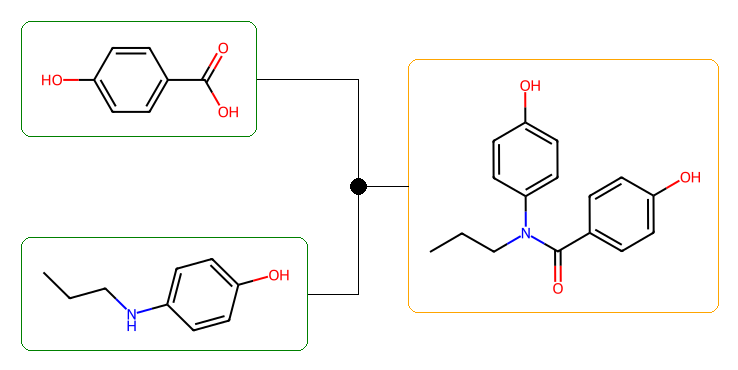

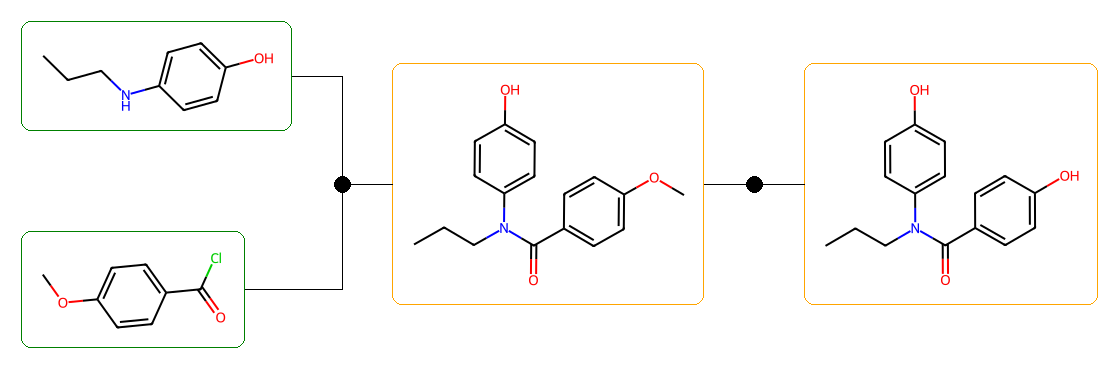

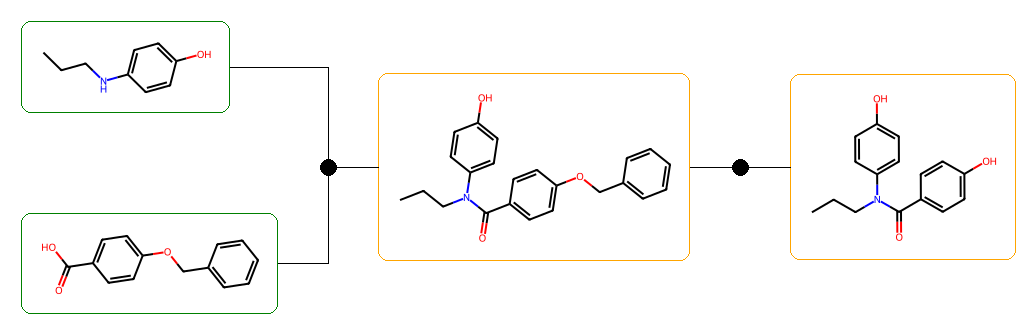

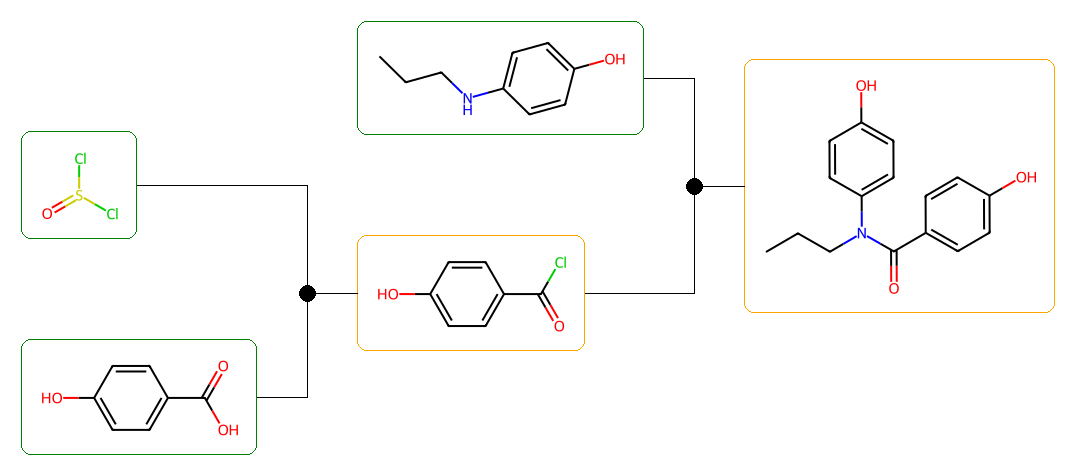

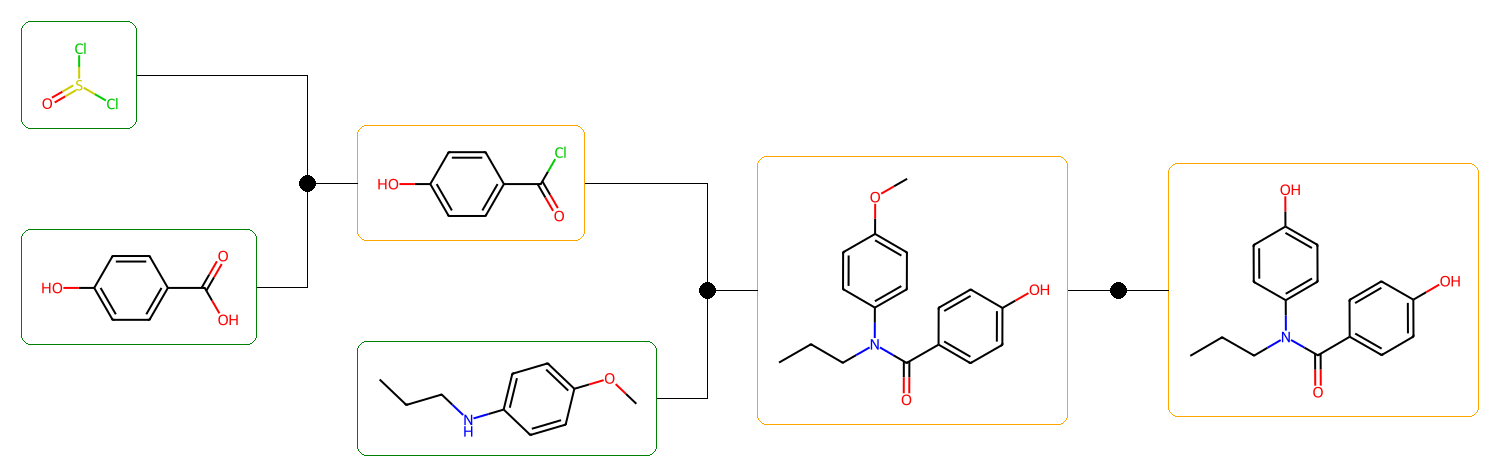

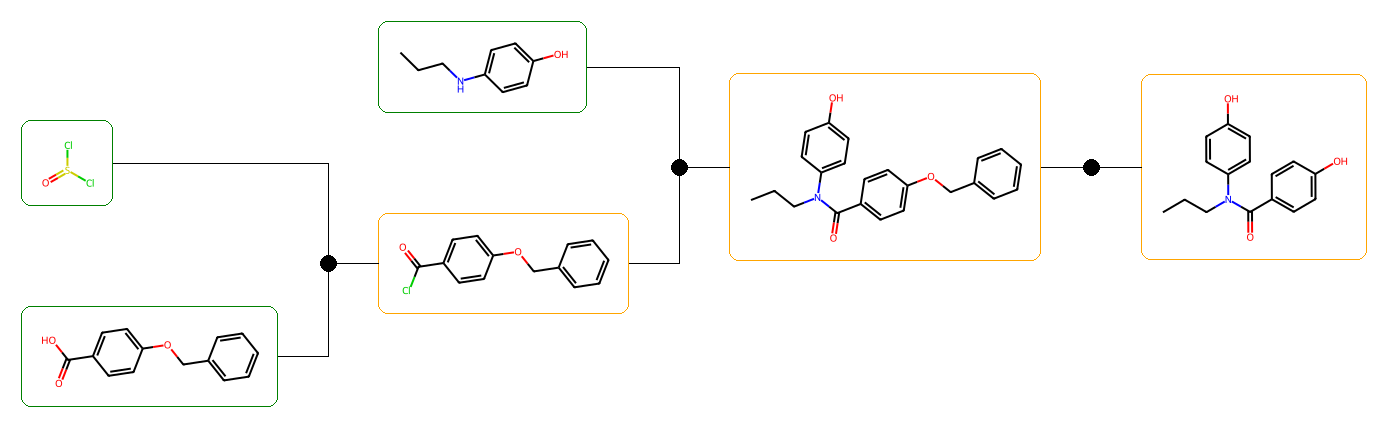

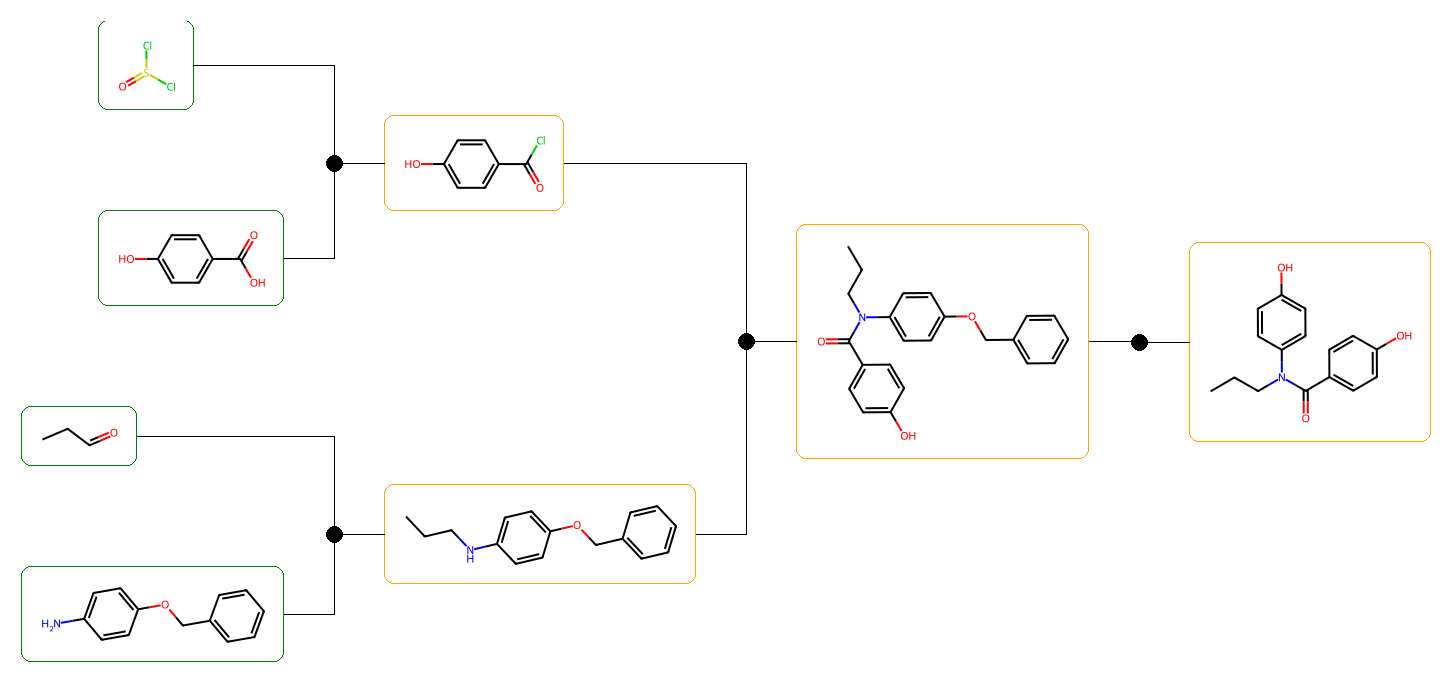

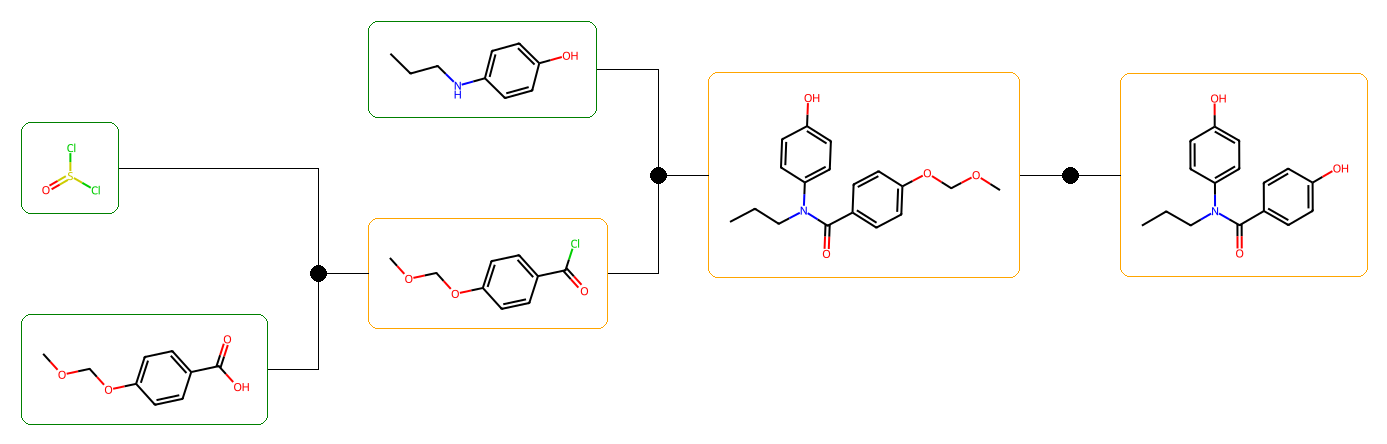

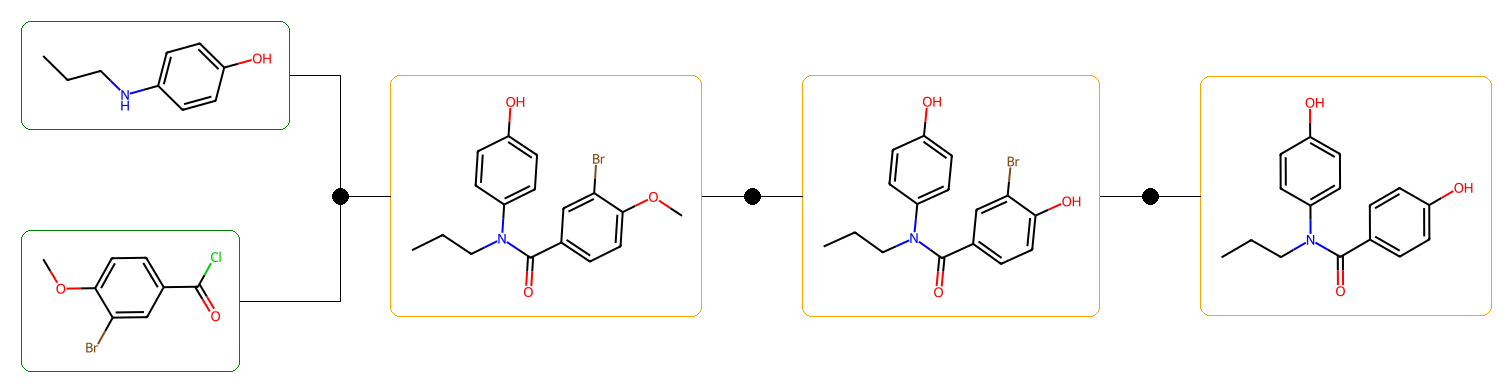

In [38]:
# Collect images of sequences
images = finder.routes.images
from IPython.display import display
for image in images:
  display(image)

In [39]:
# Now let's compile data as before
all_sequences_data2 = {}
# Loop through all reaction trees (sequences)
for seq_idx, seq in enumerate(sequences):
    # Get score for the current sequence
    scores = finder.routes.all_scores[seq_idx]
    
    # Create a dictionary to hold the data for the current sequence
    seq_data = {
        "target_smiles": seq.root.smiles,
        "in_stock": seq.in_stock(seq.root),
        "state_score": scores["state score"],
        "list_of_reactions": [],
    }
    
    # Loop through all reactions in the current sequence
    for reaction in seq.reactions():
        # Create a dictionary to hold data for each reaction
        rxn_data = {
            "rxn_target_smiles": reaction.mol.smiles,
            "library_occurence": reaction.metadata["library_occurence"],
            "template": reaction.metadata["template"],
            "mapped_reaction_smiles": reaction.metadata["mapped_reaction_smiles"],
            "mol_children": [
                {"smiles": reactant.smiles, "in_stock": seq.in_stock(reactant)}
                for reactant in reaction.reactants[0]
            ]
        }
        # Add the reaction data to the sequence dictionary
        seq_data["list_of_reactions"].append(rxn_data)
    
    # Append the sequence data to the list of all sequences
    all_sequences_data2[f'seq{seq_idx}'] = seq_data

all_sequences_data2

{'seq0': {'target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
  'in_stock': False,
  'state_score': 0.9976287063411217,
  'list_of_reactions': [{'rxn_target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
    'library_occurence': 265,
    'template': '[C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]',
    'mapped_reaction_smiles': '[CH3:1][CH2:2][CH2:3][N:4]([C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1>>[C:5](=[O:6])([c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[OH:21].[CH3:1][CH2:2][CH2:3][NH:4][c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1',
    'mol_children': [{'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True},
     {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}]}]},
 'seq1': {'target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
  'in_stock': False,
  'state_score': 0.994039853898894,
  'list_of_reactions': [{'rxn_target_smiles

In [40]:
# we can loop through the data like this
for key,value in all_sequences_data2.items():
    print(value)

{'target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1', 'in_stock': False, 'state_score': 0.9976287063411217, 'list_of_reactions': [{'rxn_target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1', 'library_occurence': 265, 'template': '[C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]', 'mapped_reaction_smiles': '[CH3:1][CH2:2][CH2:3][N:4]([C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1>>[C:5](=[O:6])([c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[OH:21].[CH3:1][CH2:2][CH2:3][NH:4][c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1', 'mol_children': [{'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}, {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}]}]}
{'target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1', 'in_stock': False, 'state_score': 0.994039853898894, 'list_of_reactions': [{'rxn_target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1', 'library_occ

seq0
state_score 0.9976287063411217
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq0, reaction 1 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 265
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


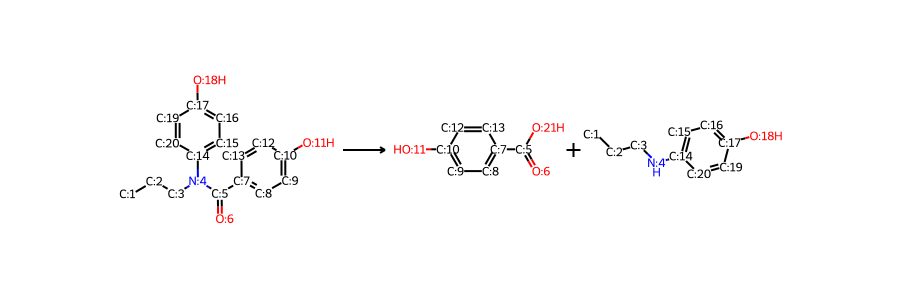

precursor mols: {'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq1
state_score 0.994039853898894
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq1, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 13100
template: [OH;D1;+0:1]-[c:2]>>C-[O;H0;D2;+0:1]-[c:2]


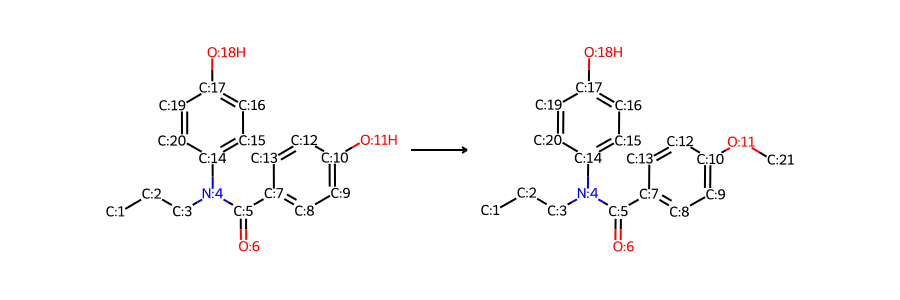

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(OC)cc1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq1, reaction 1 data:

target smiles: CCCN(C(=O)c1ccc(OC)cc1)c1ccc(O)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


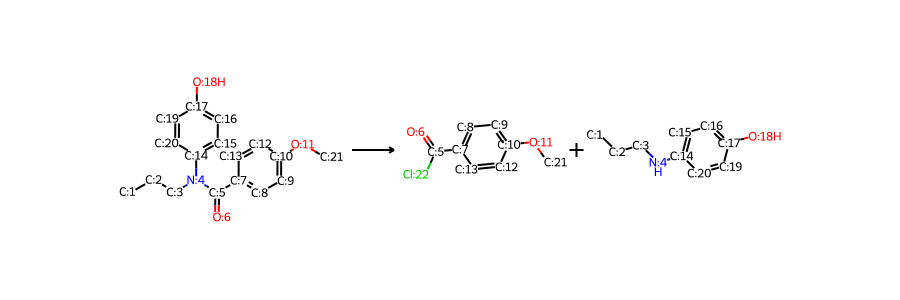

precursor mols: {'smiles': 'COc1ccc(C(=O)Cl)cc1', 'in_stock': True}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq2
state_score 0.994039853898894
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq2, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 161
template: [#7:1]-[C:2](=[O;D1;H0:3])-[c:4]1:[c:5]:[c:6]:[c:7](-[OH;D1;+0:8]):[c:9]:[c:10]:1>>[#7:1]-[C:2](=[O;D1;H0:3])-[c:4]1:[c:5]:[c:6]:[c:7](-[O;H0;D2;+0:8]-C-c2:c:c:c:c:c:2):[c:9]:[c:10]:1


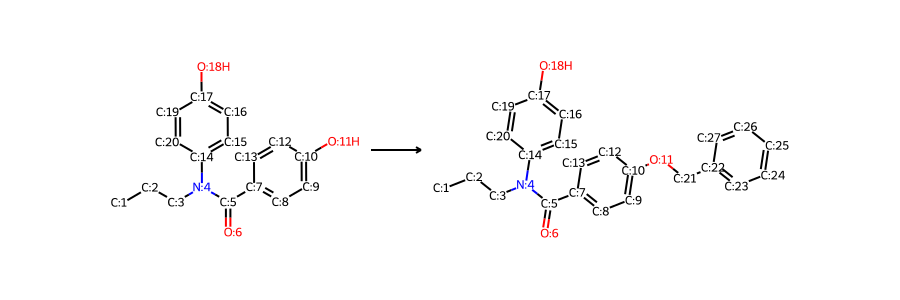

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(OCc2ccccc2)cc1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq2, reaction 1 data:

target smiles: CCCN(C(=O)c1ccc(OCc2ccccc2)cc1)c1ccc(O)cc1
library_occurence: 265
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


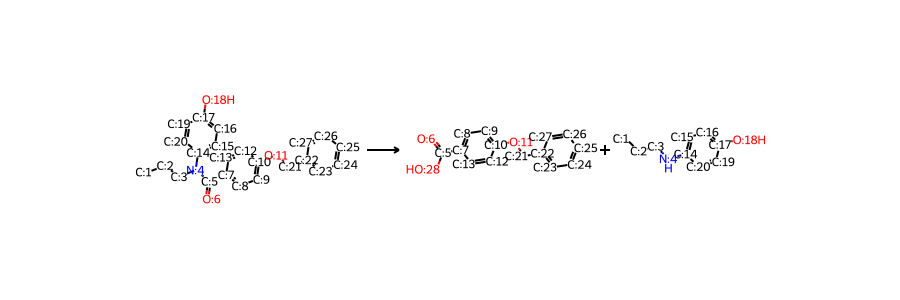

precursor mols: {'smiles': 'O=C(O)c1ccc(OCc2ccccc2)cc1', 'in_stock': True}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq3
state_score 0.994039853898894
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq3, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


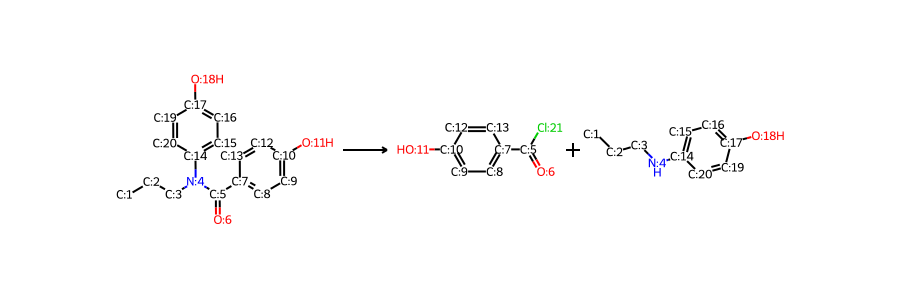

precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)cc1', 'in_stock': False}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
seq3, reaction 1 data:

target smiles: O=C(Cl)c1ccc(O)cc1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


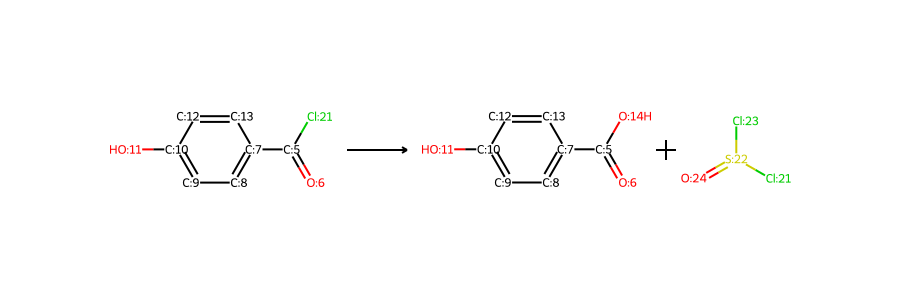

precursor mols: {'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
 
 
--------------------------------------------



seq4
state_score 0.9865529289315002
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq4, reaction 3 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 551
template: [#7:6]-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:8]:[c:7]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[#7:6]):[c:7]:[c:8]:1


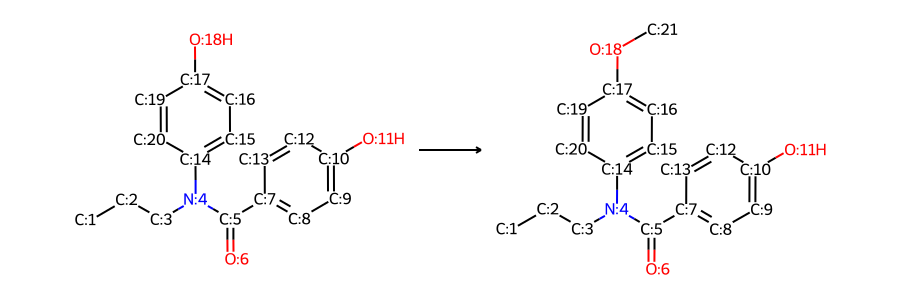

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(OC)cc1', 'in_stock': False}
 
 
seq4, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(OC)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


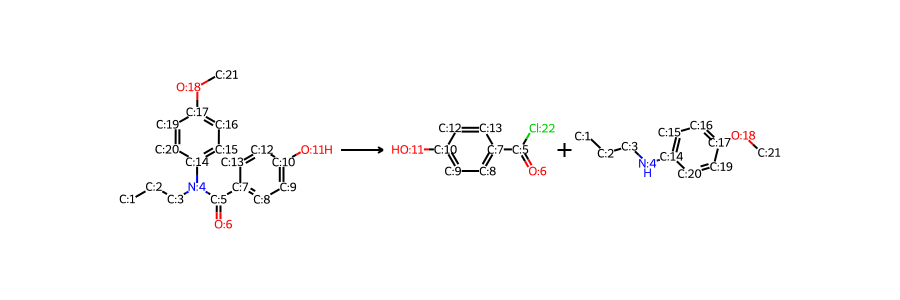

precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)cc1', 'in_stock': False}
precursor mols: {'smiles': 'CCCNc1ccc(OC)cc1', 'in_stock': True}
 
 
seq4, reaction 1 data:

target smiles: O=C(Cl)c1ccc(O)cc1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


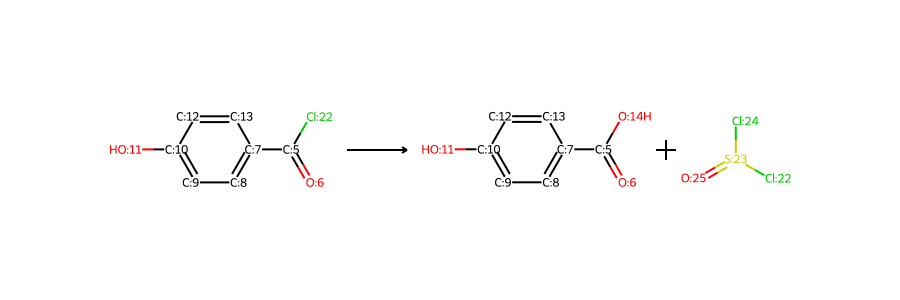

precursor mols: {'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
 
 
--------------------------------------------



seq5
state_score 0.9865529289315002
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq5, reaction 3 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 161
template: [#7:1]-[C:2](=[O;D1;H0:3])-[c:4]1:[c:5]:[c:6]:[c:7](-[OH;D1;+0:8]):[c:9]:[c:10]:1>>[#7:1]-[C:2](=[O;D1;H0:3])-[c:4]1:[c:5]:[c:6]:[c:7](-[O;H0;D2;+0:8]-C-c2:c:c:c:c:c:2):[c:9]:[c:10]:1


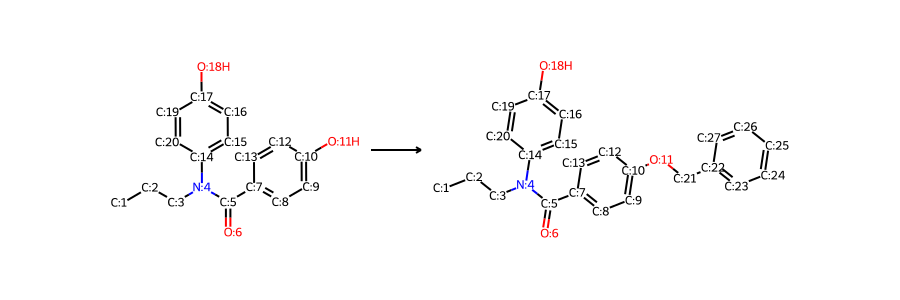

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(OCc2ccccc2)cc1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq5, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(OCc2ccccc2)cc1)c1ccc(O)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


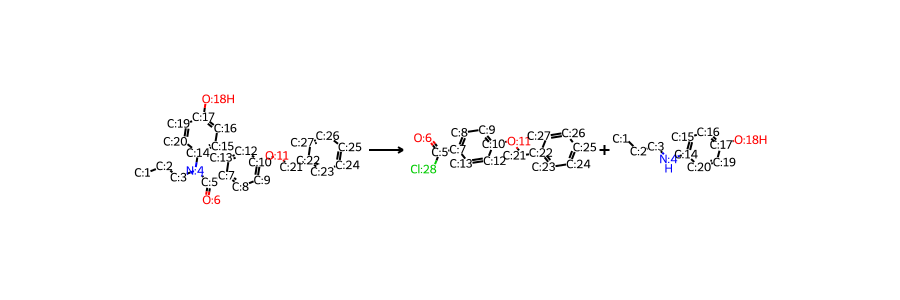

precursor mols: {'smiles': 'O=C(Cl)c1ccc(OCc2ccccc2)cc1', 'in_stock': False}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
seq5, reaction 1 data:

target smiles: O=C(Cl)c1ccc(OCc2ccccc2)cc1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


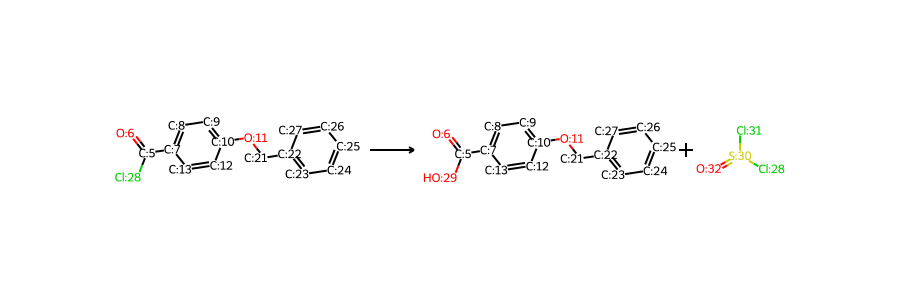

precursor mols: {'smiles': 'O=C(O)c1ccc(OCc2ccccc2)cc1', 'in_stock': True}
precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
 
 
--------------------------------------------



seq6
state_score 0.9865529289315002
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq6, reaction 4 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 6005
template: [OH;D1;+0:2]-[c:1]>>[c:1]-[O;H0;D2;+0:2]-C-c1:c:c:c:c:c:1


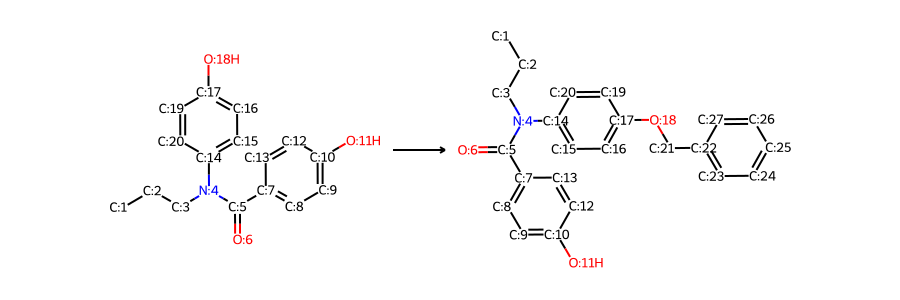

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(OCc2ccccc2)cc1', 'in_stock': False}
 
 
seq6, reaction 3 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(OCc2ccccc2)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


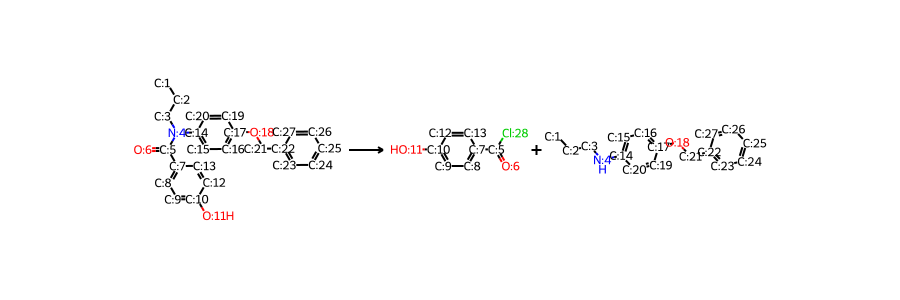

precursor mols: {'smiles': 'O=C(Cl)c1ccc(O)cc1', 'in_stock': False}
precursor mols: {'smiles': 'CCCNc1ccc(OCc2ccccc2)cc1', 'in_stock': False}
 
 
seq6, reaction 2 data:

target smiles: O=C(Cl)c1ccc(O)cc1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


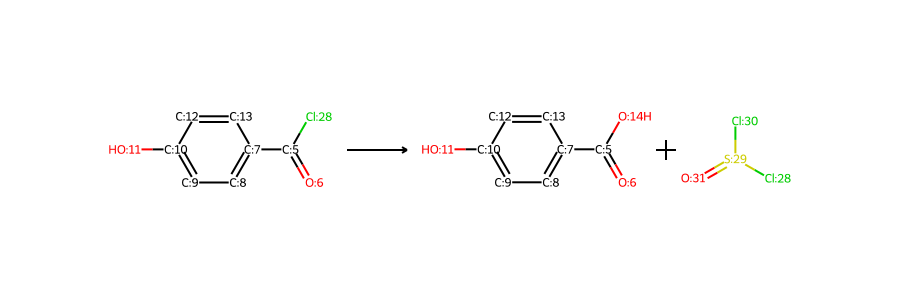

precursor mols: {'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
 
 
seq6, reaction 1 data:

target smiles: CCCNc1ccc(OCc2ccccc2)cc1
library_occurence: 626
template: [C:2]-[CH2;D2;+0:1]-[NH;D2;+0:3]-[c:4]>>O=[CH;D2;+0:1]-[C:2].[NH2;D1;+0:3]-[c:4]


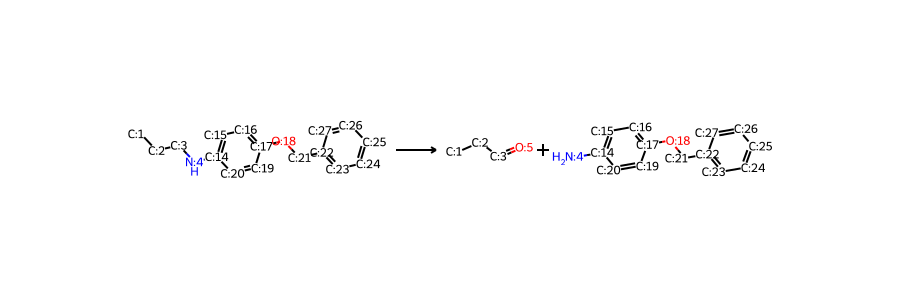

precursor mols: {'smiles': 'CCC=O', 'in_stock': True}
precursor mols: {'smiles': 'Nc1ccc(OCc2ccccc2)cc1', 'in_stock': True}
 
 
--------------------------------------------



seq7
state_score 0.9865529289315002
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq7, reaction 3 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 634
template: [OH;D1;+0:1]-[c:2]>>C-O-C-[O;H0;D2;+0:1]-[c:2]


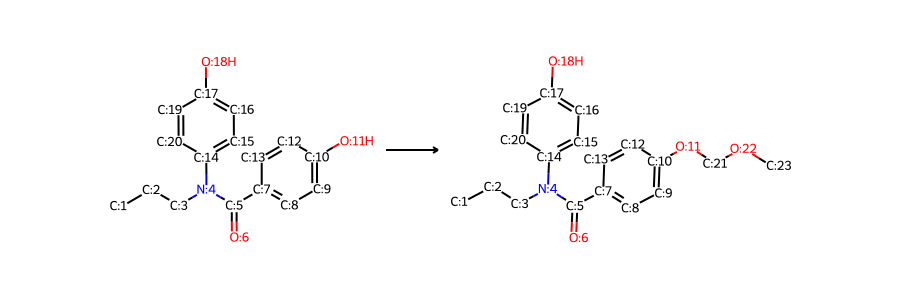

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(OCOC)cc1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq7, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(OCOC)cc1)c1ccc(O)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


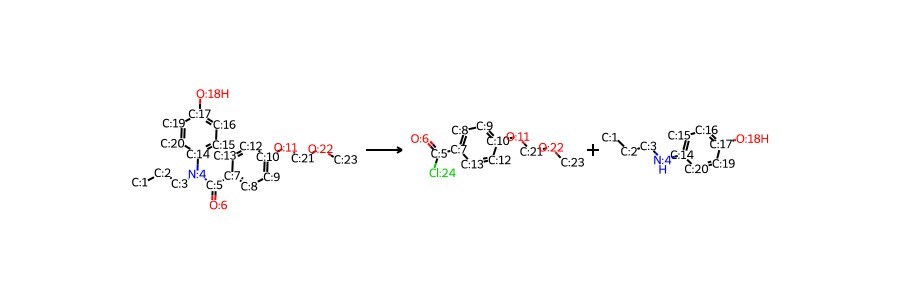

precursor mols: {'smiles': 'COCOc1ccc(C(=O)Cl)cc1', 'in_stock': False}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
seq7, reaction 1 data:

target smiles: COCOc1ccc(C(=O)Cl)cc1
library_occurence: 2874
template: [Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]>>Cl-S(=O)-[Cl;H0;D1;+0:1].O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]


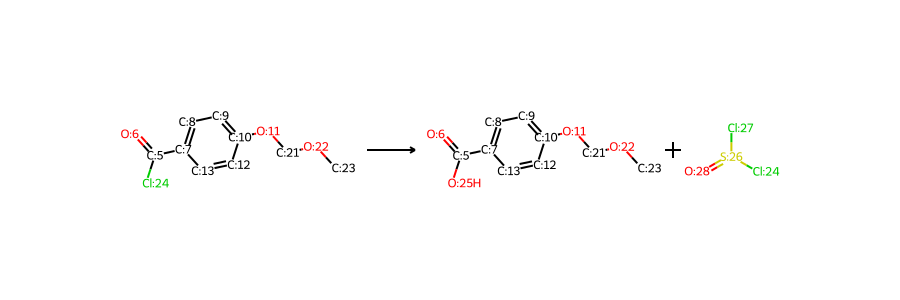

precursor mols: {'smiles': 'COCOc1ccc(C(=O)O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'O=S(Cl)Cl', 'in_stock': True}
 
 
--------------------------------------------



seq8
state_score 0.9865529289315002
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq8, reaction 3 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 433
template: [c:2]:[cH;D2;+0:1]:[c:3]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3]


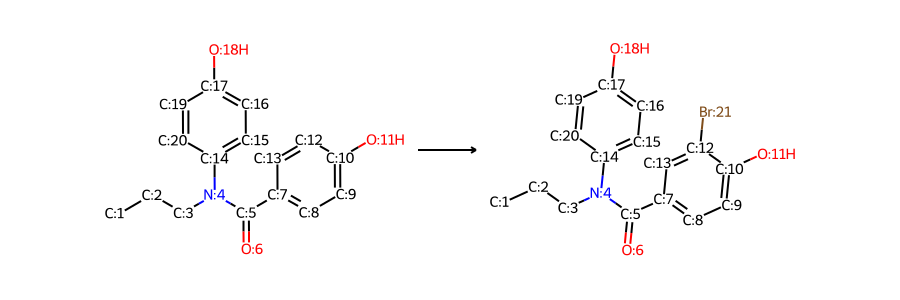

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(O)c(Br)c1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq8, reaction 2 data:

target smiles: CCCN(C(=O)c1ccc(O)c(Br)c1)c1ccc(O)cc1
library_occurence: 284
template: [#7:7]-[C:6](=[O;D1;H0:8])-[c:5]1:[c:4]:[c:3]:[c:2](-[OH;D1;+0:1]):[c:10]:[c:9]:1>>C-[O;H0;D2;+0:1]-[c:2]1:[c:3]:[c:4]:[c:5](-[C:6](-[#7:7])=[O;D1;H0:8]):[c:9]:[c:10]:1


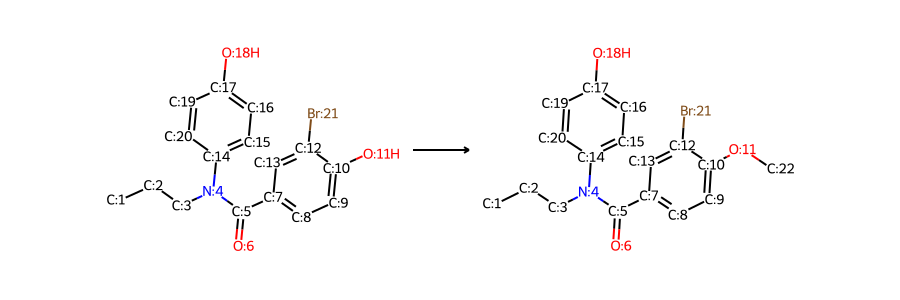

precursor mols: {'smiles': 'CCCN(C(=O)c1ccc(OC)c(Br)c1)c1ccc(O)cc1', 'in_stock': False}
 
 
seq8, reaction 1 data:

target smiles: CCCN(C(=O)c1ccc(OC)c(Br)c1)c1ccc(O)cc1
library_occurence: 501
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


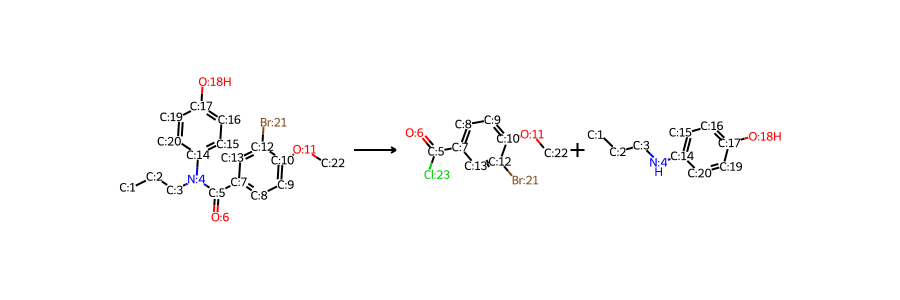

precursor mols: {'smiles': 'COc1ccc(C(=O)Cl)cc1Br', 'in_stock': True}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
--------------------------------------------





In [41]:
# Now we can depict the reactions with RDKit.
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

for key,value in all_sequences_data2.items():
    print(str(key))
    print("state_score " + str(value["state_score"]))
    print("Target smiles: " + str(value['target_smiles']) + ", in_stock': " + str(value["in_stock"]))
    print(" ")
    
    total_reactions = len(value['list_of_reactions'])
    for i, reaction in enumerate(value['list_of_reactions']):
        rxn_num = total_reactions - i # reverse rxn numbers
        print(str(key) + ", reaction " + str(rxn_num) +  " data:\n")
        print("target smiles: " + reaction["rxn_target_smiles"])
        print("library_occurence: " + str(reaction["library_occurence"]))
        print("template: " + reaction["template"])

        # Draw reaction with RDKit using rdMolDraw2D module
        rxn_smiles = reaction["mapped_reaction_smiles"]
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        drawer = rdMolDraw2D.MolDraw2DSVG(900,300)
        drawer.drawOptions().addStereoAnnotation = False
        drawer.DrawReaction(rxn,highlightByReactant=False)
        drawer.FinishDrawing()
        display(SVG(drawer.GetDrawingText()))

        for smiles in reaction['mol_children']:
            print("precursor mols: " + str(smiles))
        print(" ")
        print(" ")

    print('--------------------------------------------\n\n\n')

In [42]:
# If you want the retrosynthesis arrow instead,
# we can do that!
os.chdir('..')
os.chdir('../X_Extras')

# Import the retro arrow functions
from draw_retro import create_rxn_svg, add_retro_arrow

In [ ]:
# all_sequences_data2.keys()

seq0
state_score 0.9976287063411217
Target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1, in_stock': False
 
seq0, reaction 1 data:

target smiles: CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1
library_occurence: 265
template: [C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]


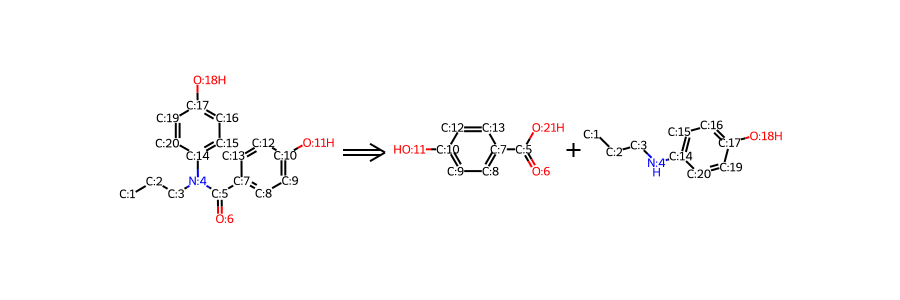

precursor mols: {'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True}
precursor mols: {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}
 
 
--------------------------------------------





In [43]:
for key,value in all_sequences_data2.items():
    if key == 'seq0': # for testing, just look at sequence 0
       print(str(key))
       print("state_score " + str(value["state_score"]))
       print("Target smiles: " + str(value["target_smiles"]) + ", in_stock': " + str(value["in_stock"]))
       print(" ")

       total_reactions = len(value['list_of_reactions'])
       for i, reaction in enumerate(value['list_of_reactions']):
           rxn_num = total_reactions - i # reverse rxn numbers
           
           print(str(key) + ", reaction " + str(rxn_num) +  " data:\n")
           print("target smiles: " + reaction["rxn_target_smiles"])
           print("library_occurence: " + str(reaction["library_occurence"]))
           print("template: " + reaction["template"])

           # Draw reaction with RDKit using retro arrow hack
           rxn_smiles = reaction["mapped_reaction_smiles"]
           rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
           rdChemReactions.SanitizeRxn(rxn)

           rxn_svg = create_rxn_svg(rxn, 900, 300)
           display(SVG(add_retro_arrow(rxn_svg)))

           for smiles in reaction['mol_children']:
               print("precursor mols: " + str(smiles))
           print(" ")
           print(" ")

       print('--------------------------------------------\n\n\n')

In [44]:
# Finally, since we saved the templates, let's take a quick look at one
# Get data for Seq0
sequence0 = all_sequences_data2['seq0']
sequence0

{'target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
 'in_stock': False,
 'state_score': 0.9976287063411217,
 'list_of_reactions': [{'rxn_target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
   'library_occurence': 265,
   'template': '[C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]',
   'mapped_reaction_smiles': '[CH3:1][CH2:2][CH2:3][N:4]([C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1>>[C:5](=[O:6])([c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[OH:21].[CH3:1][CH2:2][CH2:3][NH:4][c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1',
   'mol_children': [{'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True},
    {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}]}]}

In [45]:
# get the last rxn, which is the one depicted right above this
sequence0['list_of_reactions'][-1]

{'rxn_target_smiles': 'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1',
 'library_occurence': 265,
 'template': '[C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]',
 'mapped_reaction_smiles': '[CH3:1][CH2:2][CH2:3][N:4]([C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1>>[C:5](=[O:6])([c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][cH:13]1)[OH:21].[CH3:1][CH2:2][CH2:3][NH:4][c:14]1[cH:15][cH:16][c:17]([OH:18])[cH:19][cH:20]1',
 'mol_children': [{'smiles': 'O=C(O)c1ccc(O)cc1', 'in_stock': True},
  {'smiles': 'CCCNc1ccc(O)cc1', 'in_stock': True}]}

In [46]:
# Get template and the rxn target smiles
template = sequence0['list_of_reactions'][-1]["template"]
template

'[C:4]-[N;H0;D3;+0:5](-[c:6])-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[NH;D2;+0:5]-[c:6]'

In [47]:
rxn_target_smiles = sequence0['list_of_reactions'][-1]["rxn_target_smiles"]
rxn_target_smiles

'CCCN(C(=O)c1ccc(O)cc1)c1ccc(O)cc1'

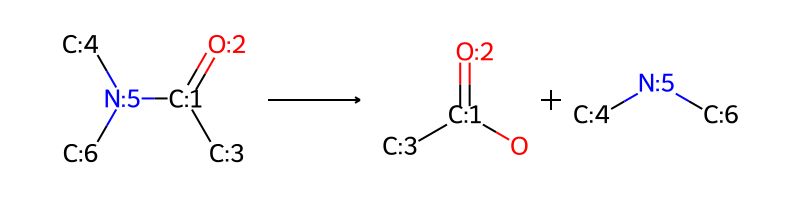

In [48]:
rxn = rdChemReactions.ReactionFromSmarts(template)
rdChemReactions.SanitizeRxn(rxn)
rxn

In [49]:
rxn.GetNumProductTemplates()

2

In [50]:
# Let's see if we get the same result as AiZynthFinder
# By applying the template with RDKit
from rdkit import Chem
product_tuples = rxn.RunReactants((Chem.MolFromSmiles(rxn_target_smiles),)) # need to input reactants as tuples (in this case, only 1)

# there can be several possible reactant sets generated
product_tuples

((<rdkit.Chem.rdchem.Mol at 0x7f54f590edc0>,
  <rdkit.Chem.rdchem.Mol at 0x7f54f598bd80>),)

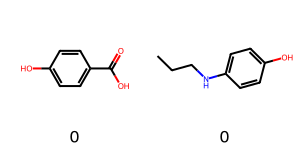

In [51]:
# Depict the reactant sets
def setup_grid(mols, num_molsPerRow=2, panel_size=150):
    molsPerRow = num_molsPerRow
    nRows = len(mols)//molsPerRow
    if len(mols)%molsPerRow:
       nRows+=1
    panelx = panel_size
    panely = panel_size
    canvasx = panelx * molsPerRow
    canvasy = panely * nRows
    drawer_grid = rdMolDraw2D.MolDraw2DCairo(canvasx,canvasy,panelx,panely)
    return drawer_grid

# PNG function
from PIL import Image
import io
# png function to view molecules
def show_png(drawing_text):

    # not sure why, but re-importing PIL
    # each time is necassary in Jupyter
    from PIL import Image
    import io
 
    bio = io.BytesIO(drawing_text)
    img = Image.open(bio)
    return img

# sanitize
product_san = []
for idx,product_set in enumerate(product_tuples):
    for product in product_set:
        Chem.SanitizeMol(product)
        product_san.append([idx, product])

# depict as a grid
mols = [item[1] for item in product_san]
labels = [str(item[0]) for item in product_san]
drawer = setup_grid(product_san, num_molsPerRow=2, panel_size=150)
drawer.DrawMolecules(mols, legends=labels)
drawer.FinishDrawing()
show_png(drawer.GetDrawingText())

In [54]:
# Check for matches to the AiZynthFinder prediction
# Get AiZynth precursor SMILES
ai_smi1 = sequence0['list_of_reactions'][-1]["mol_children"][0]['smiles']
ai_smi1

'O=C(O)c1ccc(O)cc1'

In [55]:
ai_smi2 = sequence0['list_of_reactions'][-1]["mol_children"][1]['smiles']
ai_smi2

'CCCNc1ccc(O)cc1'

In [56]:
# Canonicalize
aizynth_prediction = (Chem.MolToSmiles(Chem.MolFromSmiles(ai_smi1)), Chem.MolToSmiles(Chem.MolFromSmiles(ai_smi2)))
aizynth_prediction

('O=C(O)c1ccc(O)cc1', 'CCCNc1ccc(O)cc1')

In [57]:
# Now we can convert the rdkit reaction outputs to canonical SMILES
rdkit_products = []
for product_set in product_tuples:
    sanitized_products = []
    for product in product_set:
        Chem.SanitizeMol(product)
        sanitized_products.append(Chem.MolToSmiles(product))
    rdkit_products.append(tuple(sanitized_products))

rdkit_products

[('O=C(O)c1ccc(O)cc1', 'CCCNc1ccc(O)cc1')]

In [58]:
# Loop through and see if there are any matches
sorted_aizynth_prediction = tuple(sorted(aizynth_prediction))
# Loop through the list and compare sorted tuples
matches = [tpl for tpl in rdkit_products if tuple(sorted(tpl)) == sorted_aizynth_prediction]

# Check if any matches were found
if matches:
    print("Match found:", matches)
else:
    print("No match found")

Match found: [('O=C(O)c1ccc(O)cc1', 'CCCNc1ccc(O)cc1')]


## Bonus/Self-study Stuff Below

In [ ]:
# Here is the aforementioned initial rxn tree parsing solution that uses recursion
# on the reaction tree dictionary output

finder.target_smiles = ""

# Perfrom the retro tree search
finder.tree_search()

# Build the routes
finder.build_routes()

# return trees as a list of python dictionaries
trees = finder.routes.dict_with_extra(include_scores=True,include_metadata=True)

In [ ]:
len(trees)

In [ ]:
# View first reaction path data
seq0 = trees[0]
seq0

In [ ]:
# Now let's experiment with indexing
# Extract state score
seq0['scores']['state score']

In [ ]:
# mapped_reaction_smiles
seq0['children'][0]['metadata']['mapped_reaction_smiles']

In [ ]:
# template
seq0['children'][0]['metadata']['template']

In [ ]:
# library occurance
seq0['children'][0]['metadata']['library_occurence']

In [ ]:
# reactants and stock status
for item in seq0['children'][0]['children']:
    print(item['smiles'], item['in_stock'])

In [ ]:
# Look at an example with more than 1 rxn
seq5 = trees[5]
seq5

In [ ]:
# Indexing becomes more challenging as there are nested children
# So it becomes a recursive exercise
# Here is the structure of the dictionary (seq5) without the values:
def print_dict(dictionary, indent = 0):
    for item in dictionary.items():
        print(" "*indent, item[0])
        if type(item[1]) is dict:
            print_dict(item[1], indent+4)
        if type(item[1]) is list:
            print_array(item[1], indent+4)

def print_array(array, indent = 0):
    for item in array:
        if type(item) is list:
            print_array(item, indent+4)
            continue
        if type(item) is dict:
            print_dict(item, indent+4)
            continue
        print(" "*indent, item)

print_dict(seq5)

In [ ]:
# function to recursively traverses rxn tree structure
# ChatGPT4 adapted
def process_tree(node, sequence_dict, current_smiles):
    # If the current node is a reaction, process the reaction details
    if node['type'] == 'reaction':
        process_reaction(node, sequence_dict, current_smiles)
    
    # Recursively process each child node, passing down the current node's SMILES
    if 'children' in node:
        for child in node['children']:
            process_tree(child, sequence_dict, node['smiles'])

# function to extract and store data from the reactions
def process_reaction(node, sequence_dict, rxn_target_smiles):
    # Extract selected metadata from the reaction node
    template = node['metadata']['template']
    rxn_smiles = node['metadata']['mapped_reaction_smiles']
    library_occurence = node['metadata']['library_occurence']
    mol_children = []

    # Get information about the reactant molecules involved in the reaction
    for subitem in node['children']:
        if subitem['type'] == 'mol':
            mol_children.append({
                'smiles': subitem['smiles'],
                'in_stock': subitem['in_stock']
            })
    
    # Create a dictionary to store the reaction information
    reaction_info = {
        'rxn_target_smiles': rxn_target_smiles, # current node smiles being transformed
        'library_occurence': library_occurence,
        'template': template,
        'mapped_reaction_smiles': rxn_smiles,
        'mol_children': mol_children # reactant mols
    }

    # Add the reaction information to the list of reactions in the sequence dictionary
    sequence_dict.setdefault('list_of_reactions', []).append(reaction_info)

# Main processing loop, iterates over each rxn sequence in the tree
processed_trees_dict = {}
for i, sequence in enumerate(trees):
    # Initialize the dictionary to store sequence details and reactions
    sequence_dict = {
        'target_smiles': sequence['smiles'],
        'in_stock': sequence['in_stock'],
        'state_score': sequence['scores']['state score'],
        'list_of_reactions': []
    }
    # Process the tree sequence
    process_tree(sequence, sequence_dict, sequence['smiles'])

    # Store the processed sequence data in the final dictionary
    processed_trees_dict[f'seq{i}'] = sequence_dict

In [ ]:
processed_trees_dict

In [ ]:
# Here is yet another solution to parsing the dictionary tree data that uses classes
# There are two classes, one for type Mols (targets/reactants) and then
# one for type Reactions. This will recursively go through the
# dictionary and extract out score, stock status,
# templates, and mapped reactions into a new dictionary.

class Mol:
    def __init__(self, mol_data):
        self.smiles = mol_data["smiles"]
        self.in_stock = mol_data["in_stock"]
        if "scores" in mol_data.keys():
            self.state_score = mol_data["scores"]["state score"]
        if "children" in mol_data.keys():
            new_reaction = mol_data["children"][0]
            self.reaction_child = Reaction(new_reaction)
        
class Reaction:
    def __init__(self, reaction_data):
        self.library_occurence = reaction_data["metadata"]["library_occurence"]
        self.template = reaction_data["metadata"]["template"]
        self.mapped_reaction_smiles = reaction_data["metadata"]["mapped_reaction_smiles"]
        self.mol_children = []
        for child in reaction_data["children"]:
            new_mol = Mol(child)
            self.mol_children.append(new_mol)

def get_proccess_dictionary(processed_tree_data):
    main_dict = {
        "smiles": processed_tree_data.smiles,
        "in_stock": processed_tree_data.in_stock,
        "state_score": processed_tree_data.state_score,
    }

    list_of_reactions = []
    process_reaction_child(processed_tree_data.smiles, processed_tree_data.reaction_child, list_of_reactions)
    main_dict["list_of_reactions"] = list_of_reactions
    return main_dict

def process_reaction_child(target_smile, reaction_child, list_of_reactions):
    reaction_data = {
        "target_smiles": target_smile,
        "library_occurence": reaction_child.library_occurence,
        "template": reaction_child.template,
        "mapped_reaction_smiles": reaction_child.mapped_reaction_smiles,
    }

    mol_children = []
    for child in reaction_child.mol_children:
        child_data = {
            "smiles": child.smiles,
            "in_stock": child.in_stock
        }
        mol_children.append(child_data)
    reaction_data["mol_children"] = mol_children
    list_of_reactions.append(reaction_data)

    for child in reaction_child.mol_children:
        if "reaction_child" in child.__dict__.keys():
            process_reaction_child(child.smiles, child.reaction_child, list_of_reactions)

In [ ]:
processed_trees = [Mol(tree) for tree in trees]

In [ ]:
get_proccess_dictionary(processed_trees[0])